In [ ]:
import sys.path
sys.path.append("..")

In [8]:
import numpy as np
import os
import pathlib
import scipy.linalg
import scipy.interpolate
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches
from IPython.display import HTML
import microstructpy
import pytictoc

from femns2d import femns2d

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
mesh = meshio.read("microstructure_mesh.vtk")

In [11]:
points = mesh.points
centers = np.load("centers.npy")
element_connectivity = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]
boundary_markers = mesh.cell_data_dict["grain"]["line"]
grain_markers = mesh.cell_data_dict['grain']['triangle']

In [12]:
lambdamax = 1.0
lambdamin = 0.1
theta0 = np.random.rand(len(np.unique(grain_markers)))*2*np.pi
theta_markers = np.array([theta0[marker] for marker in grain_markers])
def stiffness_fn(i):
    theta = theta_markers[i]
    Q = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    D = np.diag([lambdamax, lambdamin])
    return Q@D@(Q.T)


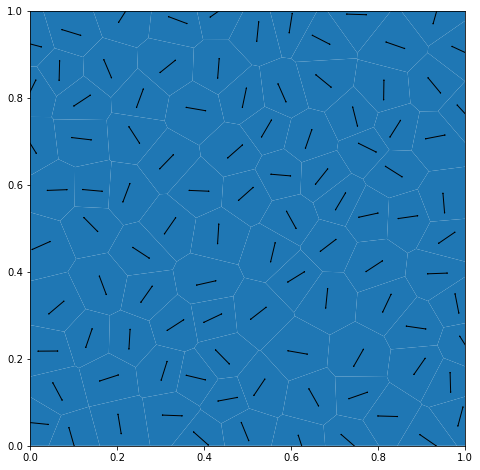

In [13]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
pmesh = microstructpy.meshing.PolyMesh.from_file("microstructure.txt")
pmesh.plot()

# plt.scatter(centers[:, 0], centers[:, 1], color='black', s=1)
arrow_length = 0.03 # You can adjust this based on your plot's scale

for center, angle in zip(centers, theta0):
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)
    arrow = matplotlib.patches.FancyArrowPatch((center[0]-dx, center[1]-dy),
                                               (center[0] + dx, center[1] + dy),
                                               arrowstyle='<|-|>', lw=1, color='black')
    ax.add_patch(arrow)

In [14]:
def solve_heat_equation(dt, steps, dirichlet_bcs):
    assembler = femns2d.MiniAssembler(mesh)
    assembler.set_main_element("linear")
    K = assembler.stiffness_matrix(stiffness_fn=stiffness_fn, stiffness_fn_type='element')
    M = assembler.mass_matrix()
    MKdt = M + dt*K
    MKdt = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], MKdt, where='u', data_dict_name="grain")
    
    Tvalues = []
    T = np.zeros(assembler.nvariables)
    T = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, T, where='u', data_dict_name="grain")
    Tvalues.append(T.copy())

    MKdt = MKdt.tocsc()
    LU = scipy.sparse.linalg.splu(MKdt)
    
    for i in range(steps):
        f = M@T
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u', data_dict_name="grain")
        MKdt = MKdt.tocsc()
        T = LU.solve(f)
        Tvalues.append(T.copy())
    T = np.array(Tvalues)
    t = np.arange(steps)*dt
    
    return T, t

In [15]:
tictoc = pytictoc.TicToc()
for validation in ['h', 'v']:
    mainpath = pathlib.Path("results_heat")
    filename = f"res_m0_random_{validation}.npz"
    savename = mainpath/filename

    lambdamax = 1.0
    lambdamin = 0.1
    angle = 0.0 if validation == 'h' else np.pi/2
    theta0 = np.ones(len(np.unique(grain_markers)))*angle
    theta_markers = np.array([theta0[marker] for marker in grain_markers])
    def stiffness_fn(i):
        theta = theta_markers[i]
        Q = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        D = np.diag([lambdamax, lambdamin])
        return Q@D@(Q.T)
    
    tictoc.tic()
    T, t = solve_heat_equation(1e-3, 10001, [[1], [3]])
    tictoc.toc()
    np.savez(savename, T=T, t=t, theta0=theta0)

Elapsed time is 239.366938 seconds.
Elapsed time is 246.741071 seconds.
